In [7]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# desired architecture: 
#     3 layer nn (300,150)
#     softmax activation layer
#     cross entropy loss (gradients will have to be accordingly made to be different for each output)

In [8]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()
#train_y = np.reshape(train_y,(train_y.shape[0],1))
#test_y = np.reshape(test_y,(test_y.shape[0],1))

print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}".format(train_y.shape))
print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

train_x shape: (60000, 28, 28)
train_y shape: (60000,)
test_x shape: (10000, 28, 28)
test_y shape: (10000,)


In [107]:

def plot_image(idx, dataset="train"):
    x = train_x[idx] if dataset == "train" else test_x[idx]
    y = train_y[idx] if dataset == "train" else test_y[idx]
    print("Showing pixel plot of a {} from {} dataset".format(y, dataset))
    plt.imshow(x)


def one_hot_encode(digit: int) -> np.array:
    encoded = np.zeros(10)
    encoded[digit] = 1
    return encoded


def reverse_encode(encoded_Y):
    return np.argmax(encoded_Y, axis=0)


def format_X(X: np.array) -> np.array:
    #assumes X is in the format (m x n0 x n1) where m is num samples, and n0 and n1 have to be collapsed into one frame
    return np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2])).T/255


def format_Y(Y: np.array) -> np.array:
    return np.array([one_hot_encode(y) for y in Y]).T


class Net:
    #input size can be variable, output layer will be a softmax of size given by train_Y
    # X needs to be of the shape n x m, where m is num samples, n is num inputs
    # Y needs to be of the shape o x m, where m is num samples, o is number of neurons in softmax layer
    def __init__(self, layer_dims, train_X, train_Y):

        self.raw_X = train_X
        self.raw_Y = train_Y
        self.train_X = format_X(train_X)
        self.train_Y = format_Y(train_Y)
        self.output_size = self.train_Y.shape[0]
        self.input_size = self.train_X.shape[0]
        assert(self.train_X.shape[1] == self.train_Y.shape[1])
        self.sample_size = train_X.shape[1]

        self.weights = [np.random.randn(layer_dims[0], self.input_size)]
        self.biases = [np.zeros((l_d, 1)) for l_d in layer_dims]

        for idx, l_d in enumerate(layer_dims[1:], 1):
            self.weights.append(np.random.randn(
                l_d, self.weights[idx-1].shape[0]))

        self.weights.append(np.random.randn(self.output_size, layer_dims[-1]))
        self.biases.append(np.zeros((self.output_size, 1)))

        self.reset_cache(self.train_X)

    @classmethod
    def reset_cache(self,X):
        self.cache = {
            'A': [X],
            # just so that Z[i] corresponds to the Z of the i-th layer (as opposed to i-1)
            'Z': [None],
            'dA': [],
            'dZ': [],
            'dW': [],
            'dB': [],
        }

    @staticmethod
    def sigmoid(z):
        return 1/(1+np.exp(z))

    @staticmethod
    def softmax(z):
        """computing softmax in a numerically stable way"""
        offset = z - np.max(z, axis=0)
        e_offset = np.exp(offset)
        return e_offset/np.sum(e_offset, axis=0, keepdims=True)

    @staticmethod
    def compute_cross_entropy_loss(Y, Yhat):
        """assumes Y and Yhat are of the shape (O x m ) where m is number of samples, o is ouputs"""
        assert (Y.shape == Yhat.shape)
        m = Y.shape[1]
        # Loss matrix over all samples, add constant to avoid -inf
        L = -np.multiply(Y, np.log(Yhat + 1e-8))
        J = (1/m)*np.sum(np.sum(L, axis=1))
        return J

    @staticmethod
    def calculate_accuracy(Y, y_pred):
        assert(Y.shape == y_pred.shape)
        return np.sum(Y == y_pred)*100/y_pred.shape[0]

    @staticmethod
    def plot_costs(costs):
        plt.figure()
        plt.plot(costs)
        plt.xlabel("epochs")
        plt.ylabel("cost")
        plt.show()

    @staticmethod
    def plot_accuracy(acc):
        plt.figure()
        plt.plot(acc)
        plt.xlabel("epochs")
        plt.ylabel("acc")
        plt.show()

        
    def forward_propagate(self):
        for idx, W in enumerate(self.weights[:-1], 1):
            self.cache['Z'].append(np.dot(W, self.cache['A'][idx-1]) + self.biases[idx-1])
            self.cache['A'].append(self.sigmoid(self.cache['Z'][idx]))
            
        self.cache['Z'].append(np.dot(self.weights[-1], self.cache['A'][-1]) + self.biases[-1])
        self.cache['A'].append(self.softmax(self.cache['Z'][-1]))

        return self.cache['A'][-1]  # Yhat


    def back_propagate(self, Y):
        """ back propapate final softmax layer individually, then loop through the remaining sigmoid layers to backprop"""
        m = Y.shape[1]
        dJ_dZ = self.cache['A'][-1] - Y
        dZ_dA = self.weights[-1]
        dZ_dW = self.cache['A'][-1]

        self.cache['dW'].append(np.dot(dJ_dZ, self.cache['A'][-2].T)/m)  # very important:
        # these derivatives are in reverse order, meaning:
        self.cache['dB'].append(np.sum(dJ_dZ, axis=1, keepdims=True)/m)
        # the 0th derivative is for the last layer
        self.cache['dA'].append(np.dot(self.weights[-1].T, dJ_dZ))

        num_layers = len(self.weights) - 1

        for idx,W in reversed(list(enumerate(self.weights[:-1], 1))):
            dJ_dZ = self.cache['dA'][num_layers-idx]*self.cache['A'][idx] * (1 - self.cache['A'][idx])  # sigmoid derivative
            self.cache['dW'].append(np.dot(dJ_dZ, self.cache['A'][idx-1].T)/m)
            self.cache['dB'].append(np.sum(dJ_dZ, axis=1, keepdims=True)/m)
            self.cache['dA'].append(np.dot(W.T,dJ_dZ))


    def update_params(self, alpha):
        num_layers = len(self.weights)
        for idx in range(num_layers):
            self.weights[idx] -= alpha*self.cache['dW'][num_layers - idx-1]
            self.biases[idx] -= alpha*self.cache['dB'][num_layers - idx -1]

    def train_model(self, epochs=15,batch_size = 600):
        costs = []
        accuracy = []
        X = self.train_X
        Y = self.train_Y
        raw_Y = self.raw_Y
        for i in range(epochs):
            increment = X.shape[1]/batch_size
            lower = 0
            upper = batch_size
            for batch in range(int(increment)):
                mini_X = X[:,lower:upper]
                mini_Y = Y[:,lower:upper]
                mini_raw_Y = raw_Y[lower:upper]
                self.reset_cache(mini_X)
                Yhat = self.forward_propagate()
                costs.append(self.compute_cross_entropy_loss(mini_Y, Yhat))
                Y_pred = reverse_encode(Yhat)
                accuracy.append(self.calculate_accuracy(mini_raw_Y, Y_pred))
                self.back_propagate(mini_Y)
                self.update_params(alpha =0.1)
                lower = upper
                upper += batch_size
            if i % 10 == 0:
                print("COST after {} epochs: {}".format(i, costs[-1]))
                print("Accuracy after {} epochs: {}".format(i, accuracy[-1]))
        self.plot_costs(costs)
        self.plot_accuracy(accuracy)
        return (costs,accuracy)

    def predict(self, test_X, test_Y):
        X = format_X(test_X)
        Y = test_Y #no need to encode
        self.reset_cache(X)
        Yhat = self.forward_propagate()
        Y_pred = reverse_encode(Yhat)
        accuracy = self.calculate_accuracy(Y,Y_pred)
        return (accuracy,Y_pred)


COST after 0 epochs: 16.086858807216124
Accuracy after 0 epochs: 2.5
COST after 10 epochs: 3.52715421360301
Accuracy after 10 epochs: 49.166666666666664
COST after 20 epochs: 2.092212720055512
Accuracy after 20 epochs: 64.0
COST after 30 epochs: 1.605275048314633
Accuracy after 30 epochs: 71.0
COST after 40 epochs: 1.2714435611785344
Accuracy after 40 epochs: 74.0


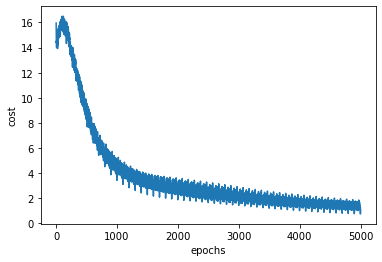

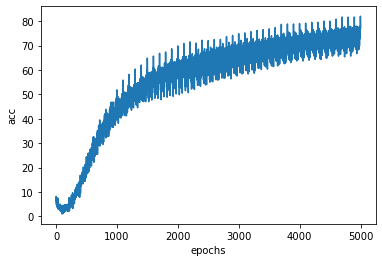

In [109]:
nn = Net([800],train_x,train_y)
cost, accuracy = nn.train_model(epochs = 50,batch_size = 600)

In [110]:
accuracy,y_pred = nn.predict(test_x,test_y)

(784, 10000)


Showing pixel plot of a 6 from test dataset
6


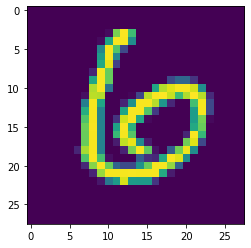

In [125]:
def check_results(idx):
    plot_image(idx,dataset="test")
    print(y_pred[idx])

check_results(11)

6